In [1]:
import uproot
import awkward as ak
import matplotlib
import matplotlib.pyplot as plt
input_tree = uproot.open({"/work/guenther/reco_tuner/data/param_data_selected_all_p.root": "Selected"})
array = input_tree.arrays()
array["dSlope_fringe"] = array["tx_ref"] - array["tx"]
array["poqmag_gev"] = 1. / ( array["signed_rel_current"] * array["qop"] * 1000. )
array["B_integral"] = array["poqmag_gev"] * array["dSlope_fringe"]

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        2.00000e+00, 2.00000e+00, 4.00000e+00, 0.00000e+00, 3.00000e+00,
        0.00000e+00, 4.00000e+00, 3.00000e+00, 1.00000e+00, 4.00000e+00,
        4.00000e+00, 1.00000e+00, 1.00000e+01, 8.00000e+00, 8.00000e+00,
        2.30000e+01, 3.20000e+01, 6.30000e+01, 8.40000e+01, 1.22000e+02,
        2.03000e+02, 3.10000e+02, 3.98000e+02, 5.90000e+02, 8.65000e+02,
        1.08700e+03, 1.55300e+03, 2.01000e+03, 2.67400e+03, 3.49500e+03,
        4.46300e+03, 5.85300e+03, 7.16800e+03, 8.92900e+03, 1.12130e+04,
        1.37320e+04, 1.69420e+04, 2.09870e+04, 2.59060e+04, 3.24750e+04,
        3.94560e+04, 4.81480e+04, 6.21400e+04, 8.28

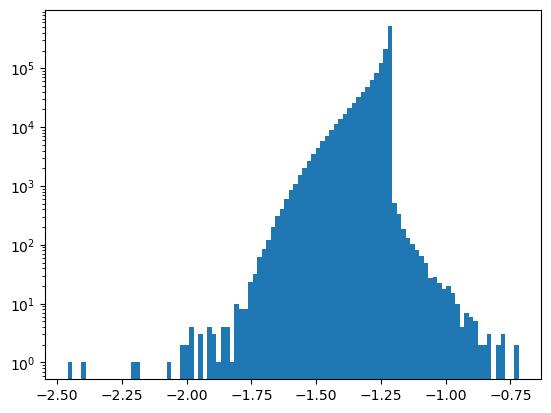

In [2]:
plt.hist(array["B_integral"], bins=100, log=True)

In [30]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np

features = [
    "ty", 
    "tx",
    "tx_ref",
]
target_feat = "B_integral"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=5, include_bias=False)
X_train_model = poly.fit_transform( X_train )
X_test_model = poly.fit_transform( X_test )
poly_features = poly.get_feature_names_out(input_features=features)
reduce = True
if reduce:
    keep = [
        #'ty',
        #'tx',
        #'tx_ref',
        #'ty tx',
        #'ty tx_ref',
        'ty^2',#keep
        'tx^2',#keep
        'tx tx_ref',#keep
        'tx_ref^2',#keep
        'ty^2 tx tx_ref',#keep
        'ty^2 tx^2',#keep
        'ty^2 tx_ref^2', #keep
        'tx^4',#keep
        'ty^4',#keep
        'tx_ref^4',#keep
        #'tx_ref^5',
        'tx^3 tx_ref', #keep
        #'tx tx_ref^3',
        #'tx^2 tx_ref^2',
        #'ty tx_ref^4',
        #'tx tx_ref^4',
        #'tx_ref^5',
    ]
    remove = [i for i, f in enumerate(poly_features) if (keep and f not in keep )]
    X_train_model = np.delete( X_train_model, remove, axis=1)
    X_test_model = np.delete( X_test_model, remove, axis=1)
    poly_features = np.delete(poly_features, remove )
    print(poly_features)
if not reduce:
    lin_reg = Lasso( alpha=0.0000001)#Lasso(fit_intercept=False, alpha=0.001)
else:
    lin_reg = LinearRegression()
lin_reg.fit( X_train_model, y_train)
y_pred_test = lin_reg.predict( X_test_model )
print("intercept=", lin_reg.intercept_)
print("coef=", dict(zip(poly_features, lin_reg.coef_)))
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print([key for key, val in dict(zip(poly_features, lin_reg.coef_)).items() if val != 0.0])

['ty^2' 'tx^2' 'tx tx_ref' 'tx_ref^2' 'ty^4' 'ty^2 tx^2' 'ty^2 tx tx_ref'
 'ty^2 tx_ref^2' 'tx^4' 'tx^3 tx_ref' 'tx_ref^4']
intercept= -1.2094486121528516
coef= {'ty^2': -2.7897043324822492, 'tx^2': -0.35976930628193077, 'tx tx_ref': -0.47138558705675454, 'tx_ref^2': -0.5600847231491961, 'ty^4': 14.009315350693472, 'ty^2 tx^2': -16.162818973243674, 'ty^2 tx tx_ref': -8.807994419844437, 'ty^2 tx_ref^2': -0.8753190393972976, 'tx^4': 2.98254201374128, 'tx^3 tx_ref': 0.9625408279466898, 'tx_ref^4': 0.10200564097830103}
r2 score= 0.9916826041227943
RMSE = 0.006014471039836984
['ty^2', 'tx^2', 'tx tx_ref', 'tx_ref^2', 'ty^4', 'ty^2 tx^2', 'ty^2 tx tx_ref', 'ty^2 tx_ref^2', 'tx^4', 'tx^3 tx_ref', 'tx_ref^4']
